# Performance Analysis

In this part we will be comparing between Spark DataFrame, Pandas DataFrame et Dask DataFrame in term of performance of doing operations such as Selecting, Filtering and Joining.

but first we will present the two tables that we will use and the question we are trying to answer, answer the question using Spark Data Frames and then do the comparaison

## Data Presentation
In this part of the analysis, we will be using the tasks usage table, and tasks events table
### Tasks events

The task events table contains the following fields:
1. timestamp
2. missing info
3. job ID
4. task index - withinthejob
5. machineID
6. event type
7. user name
8. scheduling class
9. priority
10. resource request for CPU cores
11. resource request for RAM
12. resource request for local disk space 
13. different-machine constraint

### Tasks usage 
The task resource usage table contains these fields: 
1. starttime - of the measurement period
2. endtime of the measurement period
3. jobID
4. taskindex
5. machineID
6. mean CPU usage rate
7. canonical memory usage
8. assigned memory usage
9. unmapped page cache memory usage 
10. total page cache memory usage
11. maximum memory usage
12. mean disk I/O time
13. mean local disk space used
14. maximum CPU usage
15. maximum disk IO time
16. cycles per instruction (CPI)
17. memory accesses per instruction (MAI)
18. sample portion
19. aggregation type

> For the coming part, we will be using 50 files for each table from 0000 to 00009 

In [1]:
#Importing libraries used in this project
import sys,timeit

from pyspark import SparkContext
from pyspark.sql import SQLContext, Row, SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType, LongType
import pyspark.sql.functions as F


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
#Setting the visualisations theme
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
#Create a spark context object with all the local available CPUs
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

In [4]:
#Create a spark session
spark = SparkSession.builder \
                .master("local") \
                .appName("tasks-events-analysis") \
                .getOrCreate()

In [5]:
# 1. Task Events DataFrame Structure
schema_task_events = StructType([
    StructField("timestamp", LongType(), True),
    StructField("missing_info", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index_job", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("username", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("cpu_request", FloatType(), True),
    StructField("memory_request", FloatType(), True),
    StructField("disk_request", FloatType(), True),
    StructField("machine_restriction", IntegerType(), True)])

# 2. Task Usage DataFrame Structure
schema_task_usage = StructType([
    StructField("start_time", LongType(), True),
    StructField("end_time", StringType(), True),
    StructField("job_id", LongType(), True),
    StructField("task_index_job", IntegerType(), True),
    StructField("machine_id", LongType(), True),
    StructField("cpu_rate", IntegerType(), True),
    StructField("canonial_memory", StringType(), True),
    StructField("assigned_memory", IntegerType(), True),
    StructField("unmapped_page_cache", IntegerType(), True),
    StructField("total_page_cache", FloatType(), True),
    StructField("max_memory_usage", FloatType(), True),
    StructField("io_time", FloatType(), True),
    StructField("local_disk_usage", FloatType(), True),
    StructField("max_disk_usage", FloatType(), True),
    StructField("max_io_time", FloatType(), True),
    StructField("cycle_per_inst", FloatType(), True),
    StructField("memory_access", FloatType(), True),
    StructField("sample_portion", FloatType(), True),
    StructField("agg_type", FloatType(), True),
    StructField("cpu_usage", FloatType(), True)])

In [6]:
#The path to the data file
path_task_event = "../data/task_events/*.csv.gz"

#Read the data into a SparkDataFrame
df_task_event = spark.read.csv(path_task_event, header = False, schema = schema_task_events)

#The path to the data file
path_task_usage = "../data/task_usage/*.csv.gz"

#Read the data into a SparkDataFrame
df_task_usage = spark.read.csv(path_task_usage, header = False, schema = schema_task_usage)

#Selecting only the columns we need
df_task_event = df_task_event.select('job_id','task_index_job','cpu_request','disk_request','memory_request')
df_task_usage = df_task_usage.select('job_id','task_index_job','cpu_usage','local_disk_usage','assigned_memory')

## Exploratory Data Analysis

In [7]:
# Calculate the number of null values for each column
df_task_event.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c) for c in df_task_event.columns]).show()

+------+--------------+-----------+------------+--------------+
|job_id|task_index_job|cpu_request|disk_request|memory_request|
+------+--------------+-----------+------------+--------------+
|     0|             0|        291|         291|           291|
+------+--------------+-----------+------------+--------------+



In [8]:
# Calculate the number of null values for each column
df_task_usage.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c) for c in df_task_usage.columns]).show()

+------+--------------+---------+----------------+---------------+
|job_id|task_index_job|cpu_usage|local_disk_usage|assigned_memory|
+------+--------------+---------+----------------+---------------+
|     0|             0|        0|               0|        2229529|
+------+--------------+---------+----------------+---------------+



In [9]:
df_task_event.count(), df_task_usage.count()

(450146, 2520773)

In [10]:
#Deleting the entries with null CPU requested and 
df_task_event = df_task_event.where(F.col('cpu_request').isNotNull())

In [11]:
#Calculate the number of null values for each column to make sure we deleted columns with null
df_task_event.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c) for c in df_task_event.columns]).show()

+------+--------------+-----------+------------+--------------+
|job_id|task_index_job|cpu_request|disk_request|memory_request|
+------+--------------+-----------+------------+--------------+
|     0|             0|          0|           0|             0|
+------+--------------+-----------+------------+--------------+



## Data Analysis
In this part we try to answer the question :
- Are there tasks that consume significantly less resources than what they requested? 
Inorder to answer this question, we will be using a thresholds of 10%.

In [12]:
#Joining the two dataframes on job_id and task_index_job
joined_df = df_task_event.join(df_task_usage, on = ['job_id','task_index_job'])

In [13]:
# Getting the machine that consume less resources then asked for
less_ressources = joined_df.filter((0.1 * joined_df["cpu_request"] > joined_df["cpu_usage"] ) & 
                   (0.1 * joined_df["memory_request"] > joined_df["assigned_memory"]) &
                   (0.1 * joined_df["disk_request"] > joined_df["local_disk_usage"]) ) 

In [14]:
tasks_asking_for_less_resources_pourcentage = less_ressources.count() / joined_df.count() * 100
print('The poucentage of tasks that ask for resources needed is {:1.2f}%'
      .format(tasks_asking_for_less_resources_pourcentage))

The poucentage of tasks that ask for resources needed is 14.73%


## Performance Analysis
To do performance analysis, we created four scripts to track the execution time of 6 operations:
- Reading Data : the time to read the data
- Selecting subset of the data: The time to select a subset of the dataset
- Join operation: the time to do a join operation
- Simple filtering: the time to do a filtering based on one condition
- Filtering on multiple conditions: the time to do a filtering on multiple conditions
- Getting the final result: the totale time to get the result

The 4 scripts aim to answer the same question that we answered above: 
- performance_analysis_pandas.py : Using pandas
- performance_analysis_dask.py : Using parallel library Dask that relies on pandas.
- performance_analysis_spark.py : Using spark with lazy evaluation
- performance_analysis_spark_not_lazy.py : Using spark with a count operation after each step to make sure to execute and get the results.
#### Notes
> - Tests are executed 20 times, and then we use the average of the 20 tests for each scenario to get the times we use in our plots.
> - For this part we used only one file for each table since it takes a while to get results.

#### Guidlines for running the scripts locally :
To run the scripts localy, first create a virtual environement using conda and the environment.yml file sent with this notebook. Please run this command on the terminal:

`conda env create -f environment.yml`

After that, you need to activate the environment using :

`conda activate minimal_ds`

And then run the scripts using:

`python scriptFile.py` 


In [15]:
#This data comes from executing the scripts on command line.
columns = ['technology',
        'read_data',
        'select',
        'join',
        'simple_filter',
        'multiple_filter',
        'get_result']

pandas_times = ['Pandas',7.148006156500002, 0.7657244411999988, 0.7475655497, 
                0.01422852570000117, 0.5442509803999996, 9.4093145441]

spark_times = ['Spark',0.24434430139999863, 0.03882590300000075, 0.013038327200000133, 
               0.004591568499998288, 0.03896013749999696, 27.228169405300005]

dask_times = ['Dask',0.04793748160000395, 0.0021919701999991046, 0.008800908700002497,
              0.0011480308000002548, 0.005737223699998873, 18.0964239503]
spark_not_lazy_times = ['Spark Not lazy',3.010151996499994, 2.5755709013999875, 6.879256021200004, 
                                          0.6139163497999988, 21.426675952899984, 61.83260609909998]

### Spark DataFrame VS Dask VS Pandas

In [16]:
data = [pandas_times,spark_times,dask_times]
df = pd.DataFrame(data, columns = columns) 
df.set_index('technology', inplace = True)
df = df.T
df.reset_index(inplace = True)
df.head()

technology,index,Pandas,Spark,Dask
0,read_data,7.148006,0.244344,0.047937
1,select,0.765724,0.038826,0.002192
2,join,0.747566,0.013038,0.008801
3,simple_filter,0.014229,0.004592,0.001148
4,multiple_filter,0.544251,0.038960,0.005737


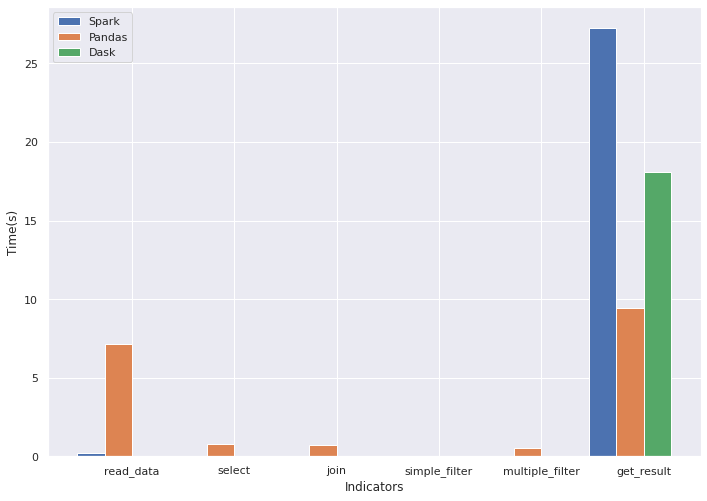

In [17]:
ind = np.arange(df['index'].shape[0])
width = 0.8
plt.bar(ind - width/3, df['Spark'], label = "Spark", 
        tick_label = df['index'], width = width/3, 
        align='edge')

plt.bar(ind, df['Pandas'], label = "Pandas", 
        tick_label = df['index'], width=width/3,
        align='edge')

plt.bar(ind + width/3, df['Dask'],label = "Dask", 
        tick_label = df['index'], width=width/3, 
        align='edge')

plt.xlabel('Indicators')
plt.ylabel('Time(s)')
plt.legend()
plt.savefig('../figures/SparkVSPandasVSDask1.png', bbox_inches='tight')
plt.show()

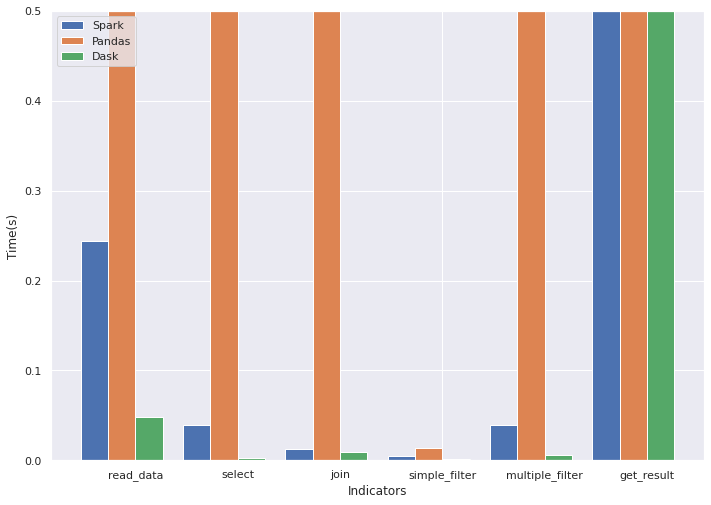

In [18]:
ind = np.arange(df['index'].shape[0])
width = 0.8
plt.bar(ind - width/3, df['Spark'], label = "Spark", 
        tick_label = df['index'], width = width/3, 
        align='edge')

plt.bar(ind, df['Pandas'], label = "Pandas", 
        tick_label = df['index'], width=width/3,
        align='edge')

plt.bar(ind + width/3, df['Dask'],label = "Dask", 
        tick_label = df['index'], width=width/3, 
        align='edge')
plt.ylim(0, 0.5)
plt.xlabel('Indicators')
plt.ylabel('Time(s)')
plt.legend()
plt.savefig('../figures/SparkVSPandasVSDask2.png', bbox_inches='tight')
plt.show()

### Spark Lazy evaluation VS Spark Without lazy evaluation

In [19]:
data = [spark_times,spark_not_lazy_times]
df = pd.DataFrame(data, columns = columns) 
df.set_index('technology', inplace = True)
df = df.T
df.reset_index(inplace = True)
df.head()

technology,index,Spark,Spark Not lazy
0,read_data,0.244344,3.010152
1,select,0.038826,2.575571
2,join,0.013038,6.879256
3,simple_filter,0.004592,0.613916
4,multiple_filter,0.038960,21.426676


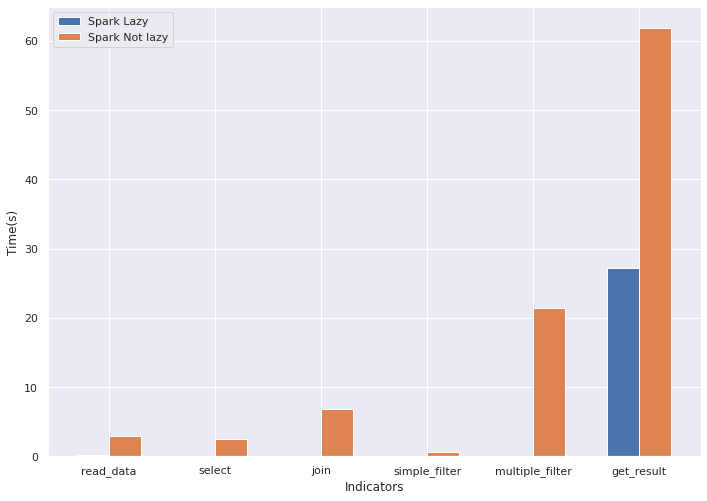

In [20]:
ind = np.arange(df['index'].shape[0])
width = 0.6
plt.bar(ind - width/2, df['Spark'], label = "Spark Lazy", 
        tick_label = df['index'], width = width/2, 
        align='edge')


plt.bar(ind , df['Spark Not lazy'],label = "Spark Not lazy", 
        tick_label = df['index'], width=width/2, 
        align='edge')

plt.xlabel('Indicators')
plt.ylabel('Time(s)')
plt.legend()
plt.savefig('../figures/lazyVSNotLazy1.png', bbox_inches='tight')
plt.show()

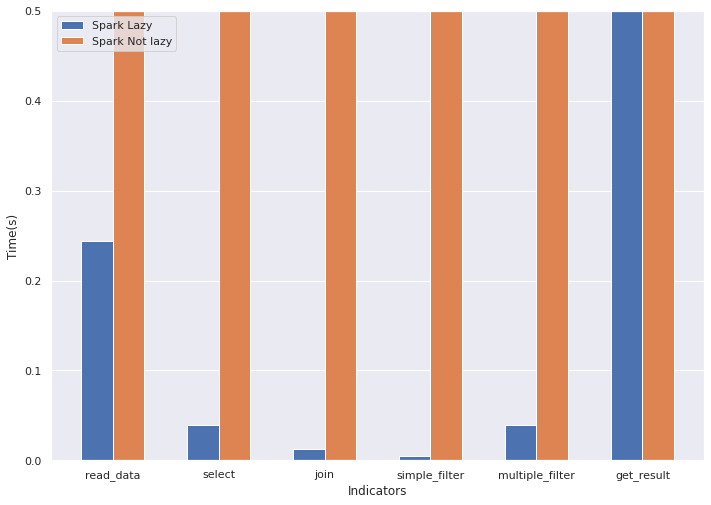

In [21]:
ind = np.arange(df['index'].shape[0])
width = 0.6
plt.bar(ind - width/2, df['Spark'], label = "Spark Lazy", 
        tick_label = df['index'], width = width/2, 
        align='edge')


plt.bar(ind , df['Spark Not lazy'],label = "Spark Not lazy", 
        tick_label = df['index'], width=width/2, 
        align='edge')
plt.ylim(0, 0.5)
plt.xlabel('Indicators')
plt.ylabel('Time(s)')
plt.legend()
plt.savefig('../figures/lazyVSNotLazy2.png', bbox_inches='tight')
plt.show()

## Performance Analysis on the cloud

In [22]:
#This data comes from executing the scripts on command line on the GCP cluster.
columns = ['technology',
        'read_data',
        'select',
        'join',
        'simple_filter',
        'multiple_filter',
        'get_result']

pandas_times = ['Pandas',17.593828454005, 4.5492394238403, 3.5494293128, 
                0.956484585, 4.5442509803999996, 31.193232756045298]

spark_times = ['Spark',0.3848294958484, 0.008483829553345, 0.030485838199, 
               0.00658483850005, 0.064938484495, 7.4958392990003]

dask_times = ['Dask',0.059394300004, 0.005484538328428, 0.0099954004,
              0.03203293304, 0.04593559439439, 24.00046845099]


In [23]:
data = [pandas_times,spark_times,dask_times]
df = pd.DataFrame(data, columns = columns) 
df.set_index('technology', inplace = True)
df = df.T
df.reset_index(inplace = True)
df.head()

technology,index,Pandas,Spark,Dask
0,read_data,17.593828,0.384829,0.059394
1,select,4.549239,0.008484,0.005485
2,join,3.549429,0.030486,0.009995
3,simple_filter,0.956485,0.006585,0.032033
4,multiple_filter,4.544251,0.064938,0.045936


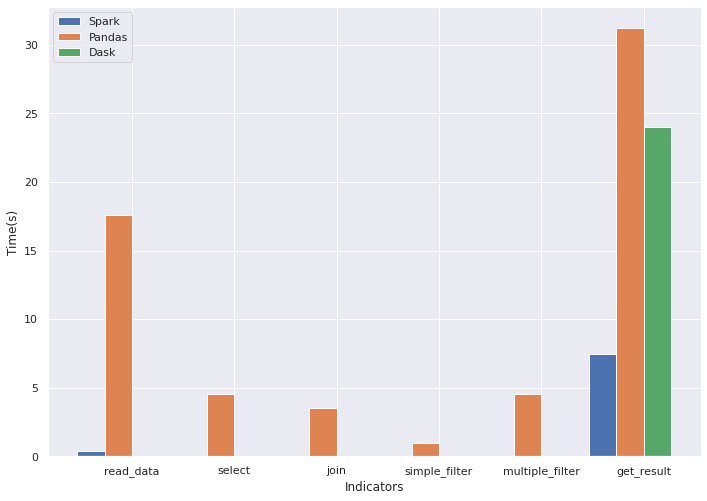

In [24]:
ind = np.arange(df['index'].shape[0])
width = 0.8
plt.bar(ind - width/3, df['Spark'], label = "Spark", 
        tick_label = df['index'], width = width/3, 
        align='edge')

plt.bar(ind, df['Pandas'], label = "Pandas", 
        tick_label = df['index'], width=width/3,
        align='edge')

plt.bar(ind + width/3, df['Dask'],label = "Dask", 
        tick_label = df['index'], width=width/3, 
        align='edge')

plt.xlabel('Indicators')
plt.ylabel('Time(s)')
plt.legend()
plt.savefig('../figures/GCPSparkVSPandasVSDask1.png', bbox_inches='tight')
plt.show()

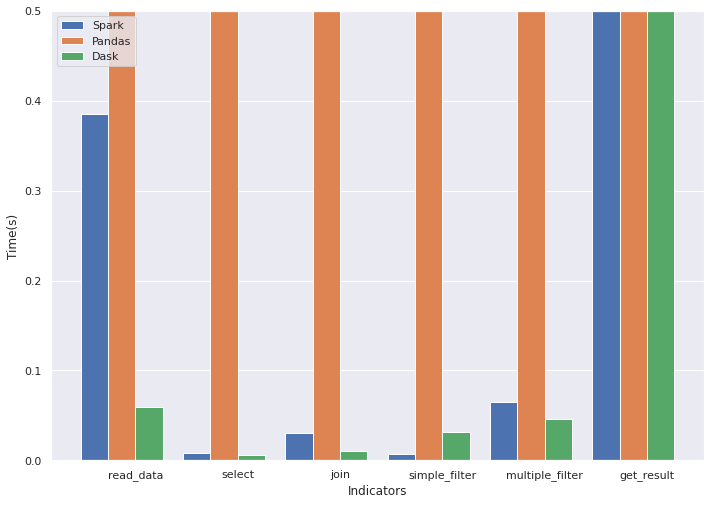

In [25]:
ind = np.arange(df['index'].shape[0])
width = 0.8
plt.bar(ind - width/3, df['Spark'], label = "Spark", 
        tick_label = df['index'], width = width/3, 
        align='edge')

plt.bar(ind, df['Pandas'], label = "Pandas", 
        tick_label = df['index'], width=width/3,
        align='edge')

plt.bar(ind + width/3, df['Dask'],label = "Dask", 
        tick_label = df['index'], width=width/3, 
        align='edge')
plt.ylim(0, 0.5)
plt.xlabel('Indicators')
plt.ylabel('Time(s)')
plt.legend()
plt.savefig('../figures/GCPSparkVSPandasVSDask2.png', bbox_inches='tight')
plt.show()